# Import Bibliotek

Ten kod importuje biblioteki niezbędne do kompleksowego modelowania i analizy danych w projekcie wykrywania fraudów:

- `pandas`, `numpy`: Umożliwiają efektywną manipulację danymi i obliczenia statystyczne.
- `matplotlib`, `seaborn`, `plotly.express`: Zapewniają wizualizację wyników w standardzie publikacji naukowych.
- `sklearn`, `imblearn.SMOTE`: Włączają preprocessing (kodowanie, skalowanie, balansowanie klas) i selekcję cech (Mutual Information).
- Modele ML: (`XGBoost`, `LightGBM`, `CatBoost`, klasyczne `sklearn`) pozwalają na testowanie różnorodnych metod klasyfikacji.
- `tensorflow`, `keras`: Umożliwiają implementację głębokich sieci neuronowych.
- `kagglehub`: Automatyzuje pobieranie danych, zwiększając odtwarzalność.

Funkcjonalność koncentruje się na przygotowaniu danych i porównaniu podejść ML/DL w zadaniu klasyfikacji.

In [1]:
# Standard libraries
import os
import gc
import warnings
import numpy as np
import pandas as pd
from datetime import datetime
from typing import List
import pickle

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import display

# Preprocessing and Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif

# Machine Learning models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# Deep Learning libraries
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.optimizers import Adam
import plotly.express as px
# Data download utilities
import kagglehub
import shutil

# Suppress warnings
warnings.filterwarnings('ignore')

2025-03-19 23:33:54.910691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered


# Zarządzanie Danymi w Wykrywaniu Fraudów

Klasa `DataManager` automatyzuje pobieranie danych z Kaggle (`load_kaggle_dataset`) i ich wczytywanie do `pandas.DataFrame` (`read_data`):

## Główne metody:

- `__init__`: Inicjalizuje nazwę datasetu i lokalny katalog zapisu.
- `load_kaggle_dataset`: Wykorzystuje `kagglehub` do pobrania danych, zapisując je w folderze "fraud-detection-dataset" z obsługą błędów.
- `read_data`: Wczytuje plik CSV, zwracając `DataFrame` z weryfikacją istnienia pliku.

## Cel

Funkcjonalność koncentruje się na zapewnieniu odtwarzalnego dostępu do danych, kluczowego w eksperymentach naukowych.

In [2]:
class DataManager:
    """Class for managing data loading and storage."""
    
    def __init__(self, dataset_name: str):
        """Initialize with dataset name and local directory."""
        self.dataset_name = dataset_name
        self.data_dir = os.getcwd()
        self.dest_path = os.path.join(self.data_dir, "fraud-detection-dataset")
    
    def load_kaggle_dataset(self) -> str:
        """Download dataset from Kaggle and save locally.
        
        Returns:
            str: Path to the saved dataset.
        Raises:
            Exception: If download fails.
        """
        try:
            path = kagglehub.dataset_download(self.dataset_name)
            if os.path.isdir(path) and not os.path.exists(self.dest_path):
                shutil.copytree(path, self.dest_path)
            elif not os.path.isdir(path):
                shutil.copy(path, self.data_dir)
            return self.dest_path
        except Exception as e:
            raise Exception(f"Dataset download failed: {str(e)}")
    
    def read_data(self, file_name: str) -> pd.DataFrame:
        """Load data from a CSV file.
        
        Args:
            file_name (str): Name of the CSV file.
        Returns:
            pd.DataFrame: Loaded DataFrame.
        Raises:
            FileNotFoundError: If the file does not exist.
        """
        file_path = os.path.join(self.dest_path, file_name)
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File {file_path} not found.")
        return pd.read_csv(file_path)

## Implementacja

Druga komórka inicjalizuje klasę dla konkretnego zbioru danych (`"ranjitmandal/fraud-detection-dataset-csv"`) i wczytuje plik `"Fraud Detection Dataset.csv"` do zmiennej `df`.

In [3]:
# Initialize and load data
data_mgr = DataManager("ranjitmandal/fraud-detection-dataset-csv")
dataset_path = data_mgr.load_kaggle_dataset()
df = data_mgr.read_data("Fraud Detection Dataset.csv")

# Eksploracyjna Analiza Danych

Klasa `DataExplorer` dostarcza narzędzia do analizy struktury danych i wizualizacji:

## Główne metody

### `explore_data`
- Wyświetla podstawowe informacje o zbiorze danych:
  - Wymiary (shape)
  - Typy danych
  - Liczba unikalnych wartości
  - Liczba brakujących wartości

### `plot_missing_values`
- Generuje wizualizacje brakujących wartości:
  - Tworzy siatkę wykresów 3x2
  - Zwraca tabelę z rozkładami
  - Automatycznie dostosowuje układ do liczby kolumn

### `plot_correlations`
- Wizualizuje zależności w danych:
  - Mapa korelacji między zmiennymi
  - Histogram rozkładu klasy docelowej (Fraudulent)

### `plot_feature_importance`
- Przedstawia rozkład istotnych cech:
  - Maksymalnie 4 kolumny w siatce
  - Automatyczne skalowanie wykresu
  - Porównanie rozkładów względem klasy docelowej

## Zastosowanie

Narzędzia te umożliwiają kompleksową analizę danych przed modelowaniem, co jest kluczowe dla zrozumienia struktury problemu i potencjalnych wyzwań w detekcji fraudów.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List

class DataExplorer:
    """Class for exploratory data analysis and visualization using Matplotlib."""
    
    @staticmethod
    def explore_data(df: pd.DataFrame) -> None:
        """Display basic dataset information."""
        print(f"Shape: {df.shape}\n")
        print("Data Types:\n", df.dtypes, "\n")
        print("Unique Values:\n", {col: df[col].nunique() for col in df.columns}, "\n")
        print("Missing Values:\n", df.isnull().sum())

    @staticmethod
    def plot_missing_values(df: pd.DataFrame) -> pd.DataFrame:
        """Visualize distribution of missing values, max 3 plots per row."""
        missing_cols = [col for col in df.columns if df[col].isnull().sum() > 0]
        if not missing_cols:
            print("No missing values found.")
            return pd.DataFrame()
        
        max_cols = 3
        n_cols = len(missing_cols)
        n_rows = (n_cols + max_cols - 1) // max_cols
        
        fig, axes = plt.subplots(n_rows, min(n_cols, max_cols), figsize=(5 * min(n_cols, max_cols), 5 * n_rows), dpi=75)
        fig.suptitle("Distribution of Values in Columns with Missing Data", fontsize=14)
        
        if n_cols == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes if n_cols <= max_cols else axes.flatten()
        else:
            axes = axes.flatten()
        
        distribution_data = {}
        for ax, col in zip(axes, missing_cols):
            if df[col].dtype in ['float64', 'int64']:
                sns.histplot(df[col].dropna(), kde=True, ax=ax, color='red')
                counts, bins = np.histogram(df[col].dropna(), bins=10)
                bin_labels = [f"{bins[j]:.2f}-{bins[j+1]:.2f}" for j in range(len(bins)-1)]
                distribution_data[col] = pd.Series(counts, index=bin_labels)
            else:
                counts = df[col].dropna().value_counts()
                ax.bar(counts.index, counts.values, color='red')
                distribution_data[col] = counts
            
            ax.set_title(col, fontsize=12)
            ax.set_xlabel(col, fontsize=10)
            ax.set_ylabel("Count", fontsize=10)
            ax.tick_params(axis='x', labelsize=8, rotation=45)
        
        for j in range(n_cols, n_rows * max_cols):
            fig.delaxes(axes[j])
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        
        result_df = pd.DataFrame(distribution_data)
        result_df.fillna(0, inplace=True)
        result_df.to_csv("missing_values_distribution.csv", index_label="Category/Bin")
        return result_df

    @staticmethod
    def plot_correlations(df: pd.DataFrame) -> None:
        """Visualize correlations and target class distribution using Matplotlib."""
        corr_matrix = df.corr().round(4)
        plt.figure(figsize=(10, 10), dpi=75)
        plt.imshow(corr_matrix, cmap='RdBu', vmin=-1, vmax=1)
        plt.colorbar(label='Correlation')
        plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right', fontsize=10)
        plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=10)
        plt.title("Correlation Heatmap", fontsize=14)
        for i in range(corr_matrix.shape[0]):
            for j in range(corr_matrix.shape[1]):
                plt.text(j, i, f"{corr_matrix.iloc[i, j]:.4f}", ha='center', va='center', fontsize=8)
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(4, 3), dpi=75)
        plt.hist(df['Fraudulent'], bins=2, color='#1f77b4', edgecolor='black')
        plt.title("Distribution of Transactions", fontsize=12)
        plt.xlabel("Class", fontsize=10)
        plt.ylabel("Count", fontsize=10)
        plt.xticks([0, 1], ['0', '1'])
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_feature_importance(df: pd.DataFrame, important_features: List[str]) -> None:
        """Visualize important features relative to Fraudulent class in a max 4-column grid."""
        n_features = len(important_features)
        max_cols = 4
        n_rows = (n_features + max_cols - 1) // max_cols
        
        fig, axes = plt.subplots(n_rows, min(n_features, max_cols), figsize=(3 * max_cols, 3 * n_rows), dpi=75)
        fig.suptitle("Important Features Relative to Fraudulent Class", fontsize=14)
        
        if n_features == 1:
            axes = np.array([axes])
        else:
            axes = axes.flatten()
        
        for i, col in enumerate(important_features):
            ax = axes[i]
            box_data = [df[df['Fraudulent'] == cls][col].dropna() for cls in df['Fraudulent'].unique()]
            # Plot boxplot with custom colors and wider boxes
            bp = ax.boxplot(box_data, patch_artist=True, widths=0.6)  # Wider boxes with widths=0.6
            
            # Customize colors: blue for class 0, orange for class 1
            colors = ['#82b1d5', '#f2b582']
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
            
            # Customize other elements
            for whisker in bp['whiskers']:
                whisker.set(color='black', linewidth=1.5)
            for cap in bp['caps']:
                cap.set(color='black', linewidth=1.5)
            for median in bp['medians']:
                median.set(color='black', linewidth=1.5)
            for flier in bp['fliers']:
                flier.set(marker='o', color=colors[1], alpha=0.5)
            
            ax.set_title(f"{col}", fontsize=12)
            ax.set_xlabel("Fraudulent", fontsize=10)
            ax.set_ylabel("Value", fontsize=10)
            ax.set_xticks([1, 2], ["0", "1"])
        
        # Hide unused axes
        for j in range(n_features, n_rows * max_cols):
            fig.delaxes(axes[j])
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# Preprocessing Danych

Klasa `DataPreprocessor` przygotowuje dane do analizy i modelowania:

## Główne metody

### `preprocess_data`
- Imputuje braki (`Transaction_Amount`: mediana)
- Usuwa kolumnę `Transaction_ID`

### `encode_categorical`
- Koduje zmienne kategoryczne:
  - `LabelEncoder` dla EDA
  - `get_dummies` dla modelowania

### `select_features`
- Wybiera cechy za pomocą Mutual Information

In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from typing import List

class DataPreprocessor:
    """Class for preprocessing data for modeling and analysis."""
    
    def __init__(self):
        """Initialize with LabelEncoder."""
        self.le = LabelEncoder()
    
    def preprocess_data(self, df: pd.DataFrame, target: str = 'Fraudulent') -> pd.DataFrame:
        """Impute missing values."""
        df_processed = df.copy()
        for col in df_processed.columns:
            if df_processed[col].dtype == 'object':
                df_processed[col] = df_processed[col].fillna('Unknown')
            else:
                if col == 'Transaction_Amount':
                    df_processed[col] = df_processed[col].fillna(df_processed[col].median())
                else:
                    df_processed[col] = df_processed[col].fillna(df_processed[col].mean())
        return df_processed.drop(['Transaction_ID'], axis=1, errors='ignore')

    
    def encode_categorical(self, df: pd.DataFrame, columns: List[str], for_eda: bool = False) -> pd.DataFrame:
        """Encode categorical variables."""
        df_encoded = df.copy()
        if for_eda:
            for col in columns:
                df_encoded[col] = self.le.fit_transform(df_encoded[col])
        else:
            df_encoded = pd.get_dummies(df_encoded, columns=columns, drop_first=True)
        return df_encoded
    
    def select_features(self, X: pd.DataFrame, y: pd.Series, threshold: float = 0) -> List[str]:
        """Select important features using Mutual Information."""
        mi_scores = mutual_info_classif(X, y, random_state=42)
        important_features = X.columns[mi_scores > threshold].tolist()
        print("Mutual Information Scores:", dict(zip(X.columns, mi_scores)))
        return important_features

## Inicjalizacja Narzędzi

```python
# Inicjalizacja
data_explorer = DataExplorer()
preprocessor = DataPreprocessor()
categorical_features = ['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method']
```

### Komponenty

#### Eksploracja Danych
- Instancja `data_explorer` klasy `DataExplorer`
- Umożliwia wizualizację i analizę struktury danych

#### Preprocessing
- Instancja `preprocessor` klasy `DataPreprocessor`
- Odpowiada za przygotowanie danych do modelowania

#### Zmienne Kategoryczne
Lista `categorical_features` zawiera kolumny wymagające kodowania:
- `Transaction_Type`
- `Device_Used`
- `Location`
- `Payment_Method`

### Zastosowanie
Ten kod inicjalizuje podstawowe narzędzia potrzebne do analizy i przetwarzania danych w projekcie wykrywania fraudów.

In [6]:
# Initialize objects
data_explorer = DataExplorer()
preprocessor = DataPreprocessor()
categorical_features = ['Transaction_Type', 'Device_Used', 'Location', 'Payment_Method']

## Analiza Struktury Danych

Wywołuje `explore_data` do wyświetlenia podstawowych informacji o zbiorze danych.

### Interpretacja Danych

#### Charakterystyka Zbioru

- **Rozmiar**: 
  - 51,000 rekordów
  - 12 cech
  - Odpowiedni do uczenia maszynowego

- **Braki**: 
  - 4.8-5% w 5 kolumnach
  - Wymaga imputacji

- **Zmienność**: 
  - Wysoka w `Transaction_Amount`
  - Niska w `Fraudulent` (niezbalansowanie klas)

In [7]:
# Explore dataset
data_explorer.explore_data(df)

Shape: (51000, 12)

Data Types:
 Transaction_ID                       object
User_ID                               int64
Transaction_Amount                  float64
Transaction_Type                     object
Time_of_Transaction                 float64
Device_Used                          object
Location                             object
Previous_Fraudulent_Transactions      int64
Account_Age                           int64
Number_of_Transactions_Last_24H       int64
Payment_Method                       object
Fraudulent                            int64
dtype: object 

Unique Values:
 {'Transaction_ID': 50000, 'User_ID': 4000, 'Transaction_Amount': 44821, 'Transaction_Type': 5, 'Time_of_Transaction': 24, 'Device_Used': 4, 'Location': 8, 'Previous_Fraudulent_Transactions': 5, 'Account_Age': 119, 'Number_of_Transactions_Last_24H': 14, 'Payment_Method': 5, 'Fraudulent': 2} 

Missing Values:
 Transaction_ID                         0
User_ID                                0
Transaction_Amo

## Wizualizacja Braków

Generuje wykresy rozkładu wartości w kolumnach z brakami i zapisuje tabelę do CSV.

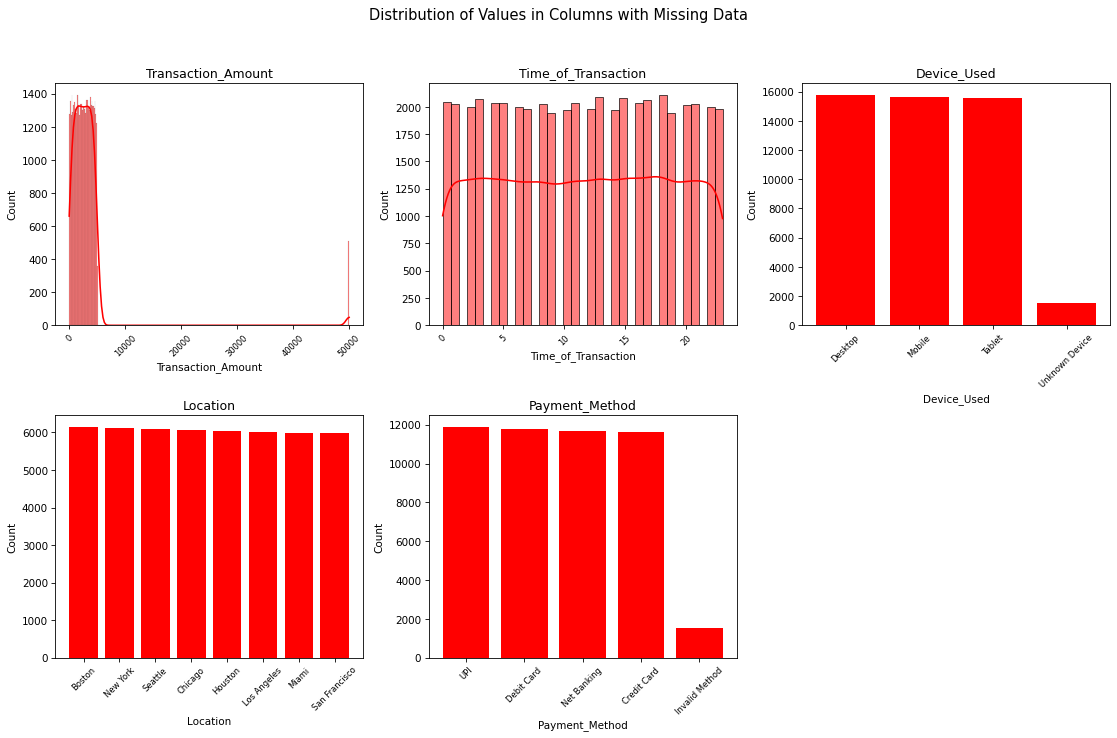

,Transaction_Amount,Time_of_Transaction,Device_Used,Location,Payment_Method
0.00-2.30,0.0,6072.0,0.0,0.0,0.0
10003.58-15002.86,0.0,0.0,0.0,0.0,0.0
11.50-13.80,0.0,4067.0,0.0,0.0,0.0
13.80-16.10,0.0,6083.0,0.0,0.0,0.0
15002.86-20002.14,0.0,0.0,0.0,0.0,0.0
16.10-18.40,0.0,4172.0,0.0,0.0,0.0
18.40-20.70,0.0,3961.0,0.0,0.0,0.0
2.30-4.60,0.0,4106.0,0.0,0.0,0.0
20.70-23.00,0.0,5997.0,0.0,0.0,0.0
20002.14-25001.42,0.0,0.0,0.0,0.0,0.0


In [8]:
# Visualize missing values
data_explorer.plot_missing_values(df)

## Interpretacja Danych

### Rozkład Braków

#### Transaction_Amount
- Dominacja niskich kwot (47,972 w przedziale 5.03-5,004.31)
- 508 transakcji o dużych wartościach
- Braki mogą dotyczyć średnich wartości

#### Time_of_Transaction
- Równomierny rozkład z małymi pikami:
  - Nocnymi
  - Popołudniowymi
- Braki potencjalnie losowe

#### Device_Used
- Równomierny rozkład między:
  - Desktop
  - Mobile
  - Tablet
- 1,530 oznaczonych jako "Unknown"
- Braki mogą maskować nietypowe urządzenia

#### Location
- Równomierny rozkład (5,985-6,149)
- Braki mogą wskazywać na:
  - Losowe występowanie
  - Transakcje online

#### Payment_Method
- Lekka przewaga:
  - UPI
  - Debit
- 1,530 oznaczonych jako "Invalid"
- Braki mogą ukrywać podejrzane metody płatności

## Analiza Statystyczna Braków

Klasa `StatisticAnalyse` bada zależność braków od `Fraudulent`:

### Metody
- `chi_square_test`: Test Chi-kwadrat dla kolumn kategorycznych
- `t_test_missing`: Test t dla kolumn numerycznych
- `analyze_missing_data`: Wykonuje testy i usuwa tymczasowe kolumny

In [9]:
from scipy.stats import chi2_contingency, ttest_ind

class StatisticAnalyse:
    """Class for statistical analysis of missing data."""
    
    @staticmethod
    def chi_square_test(df: pd.DataFrame, column: str, target: str = 'Fraudulent') -> tuple:
        """Perform Chi-square test for categorical column vs target."""
        df[f'{column}_is_missing'] = df[column].isnull().astype(int)
        contingency_table = pd.crosstab(df[f'{column}_is_missing'], df[target])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        return chi2, p_value, contingency_table, expected
    
    @staticmethod
    def t_test_missing(df: pd.DataFrame, column: str, target: str = 'Fraudulent') -> tuple:
        """Perform t-test for numerical column missingness vs target."""
        df[f'{column}_is_missing'] = df[column].isnull().astype(int)
        missing_fraud = df[df[f'{column}_is_missing'] == 1][target]
        not_missing_fraud = df[df[f'{column}_is_missing'] == 0][target]
        t_stat, p_value = ttest_ind(missing_fraud, not_missing_fraud, equal_var=False)
        return t_stat, p_value, missing_fraud.mean(), not_missing_fraud.mean()
    
    @staticmethod
    def analyze_missing_data(df: pd.DataFrame) -> None:
        """Analyze missing data and remove temporary columns."""
        categorical_cols = ['Device_Used', 'Location', 'Payment_Method']
        numeric_cols = ['Transaction_Amount', 'Time_of_Transaction']
        
        print("\n=== Chi-square Tests for Categorical Columns ===")
        for col in categorical_cols:
            chi2, p_value, contingency_table, expected = StatisticAnalyse.chi_square_test(df, col)
            print(f"\nColumn: {col}")
            print(f"Chi2: {chi2:.4f}, p-value: {p_value:.4f}")
            print("Contingency Table:\n", contingency_table.to_string())
            print("Expected Values:\n", pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns).to_string())
        
        print("\n=== T-tests for Numerical Columns ===")
        for col in numeric_cols:
            t_stat, p_value, mean_missing, mean_not_missing = StatisticAnalyse.t_test_missing(df, col)
            print(f"\nColumn: {col}")
            print(f"T-stat: {t_stat:.4f}, p-value: {p_value:.4f}")
            print(f"Mean Fraudulent (missing): {mean_missing:.4f}")
            print(f"Mean Fraudulent (not missing): {mean_not_missing:.4f}")
        
        missing_cols = [col for col in df.columns if col.endswith('_is_missing')]
        df.drop(columns=missing_cols, inplace=True)
        print("\nRemoved temporary columns:", missing_cols)

# Run analysis
statistic_analyse = StatisticAnalyse()
statistic_analyse.analyze_missing_data(df)


=== Chi-square Tests for Categorical Columns ===

Column: Device_Used
Chi2: 8.0595, p-value: 0.0045
Contingency Table:
 Fraudulent                  0     1
Device_Used_is_missing             
0                       46169  2358
1                        2321   152
Expected Values:
 Fraudulent                         0            1
Device_Used_is_missing                           
0                       46138.710392  2388.289608
1                        2351.289608   121.710392

Column: Location
Chi2: 0.0303, p-value: 0.8618
Contingency Table:
 Fraudulent               0     1
Location_is_missing             
0                    46066  2387
1                     2424   123
Expected Values:
 Fraudulent                      0            1
Location_is_missing                           
0                    46068.352353  2384.647647
1                     2421.647647   125.352353

Column: Payment_Method
Chi2: 2.3325, p-value: 0.1267
Contingency Table:
 Fraudulent                     0     

### Interpretacja Danych

#### Zależność Braków od Klasy

- **Device_Used**:
  - p=0.0045 < 0.05 – braki zależne (MNAR)
  - 6.15% fraudów z brakami vs. 4.86% bez
  - Potencjalny sygnał oszustw

- **Location**:
  - p=0.8618 – braki losowe (MCAR)
  - Brak wzorców

- **Payment_Method**:
  - p=0.1267 – braki losowe (MCAR)
  - Brak zależności

- **Transaction_Amount**:
  - p=0.9268 – braki losowe (MCAR)
  - Brak wpływu

- **Time_of_Transaction**:
  - p=0.4437 – braki losowe (MCAR)
  - Brak wpływu

## Przygotowanie Danych

### Przetwarzanie Danych
```python
df_cleaned = preprocessor.preprocess_data(df)
df_eda = preprocessor.encode_categorical(df_cleaned, categorical_features, for_eda=True)
df_train = preprocessor.encode_categorical(df_cleaned, categorical_features, for_eda=False)
```

### Transformacje
- **Imputacja braków**:
  - Wykonana przez `preprocess_data`
  - Zachowuje strukturę danych

- **Kodowanie zmiennych**:
  - `df_eda`: `LabelEncoder` dla analizy eksploracyjnej
  - `df_train`: Kodowanie one-hot dla modelowania

### Zmienne Kategoryczne
```python
categorical_features = [
    'Transaction_Type',
    'Device_Used',
    'Location',
    'Payment_Method'
]
```

In [10]:
# Preprocess data
df_cleaned = preprocessor.preprocess_data(df)
df_eda = preprocessor.encode_categorical(df_cleaned, categorical_features, for_eda=True)
df_train = preprocessor.encode_categorical(df_cleaned, categorical_features, for_eda=False)

## Analiza Korelacji

### Wizualizacja
```python
data_explorer.plot_correlations(df_eda)
```

### Komponenty
- **Mapa korelacji**:
  - Heatmapa wszystkich zmiennych
  - Skala kolorów RdBu (-1 do 1)
  - Dokładność do 4 miejsc po przecinku

- **Rozkład klasy docelowej**:
  - Histogram `Fraudulent`
  - Pokazuje niezbalansowanie klas
  - Szerokość słupków: 0.2

### Interpretacja
- Pozwala zidentyfikować:
  - Silnie skorelowane zmienne
  - Potencjalne problemy z współliniowością
  - Zmienne istotne dla detekcji fraudów

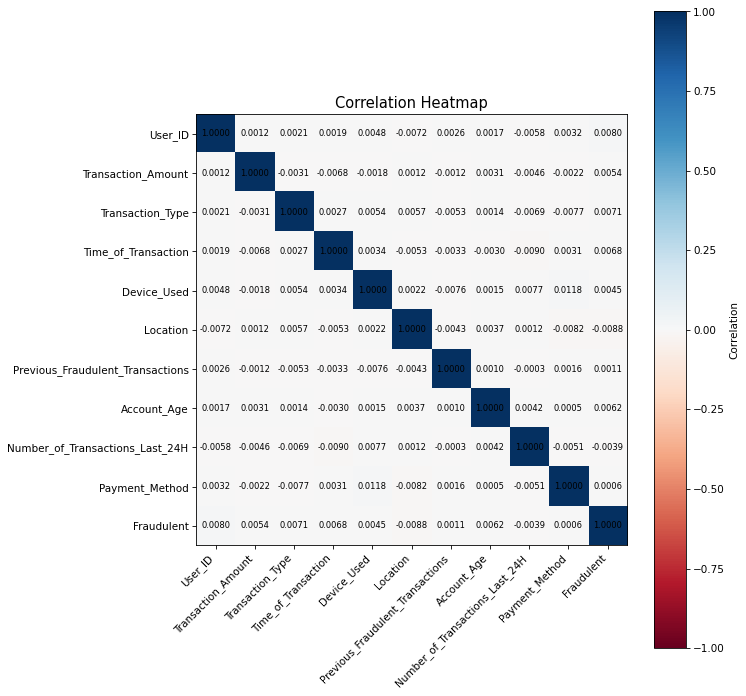

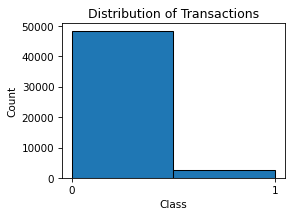

In [11]:
# Visualize correlations
data_explorer.plot_correlations(df_eda)

## Selekcja i Wizualizacja Cech

Wybiera cechy za pomocą Mutual Information i wizualizuje ich rozkład względem `Fraudulent`.

Mutual Information Scores: {'User_ID': 0.0006158604683910163, 'Transaction_Amount': 0.00037408389065896053, 'Transaction_Type': 0.0024876297205658204, 'Time_of_Transaction': 0.001441748423968603, 'Device_Used': 0.0026999746445337536, 'Location': 0.0020204327289083945, 'Previous_Fraudulent_Transactions': 0.000723333005768545, 'Account_Age': 0.0005292579573350498, 'Number_of_Transactions_Last_24H': 0.0002494470312532915, 'Payment_Method': 0.0009786948028795983}


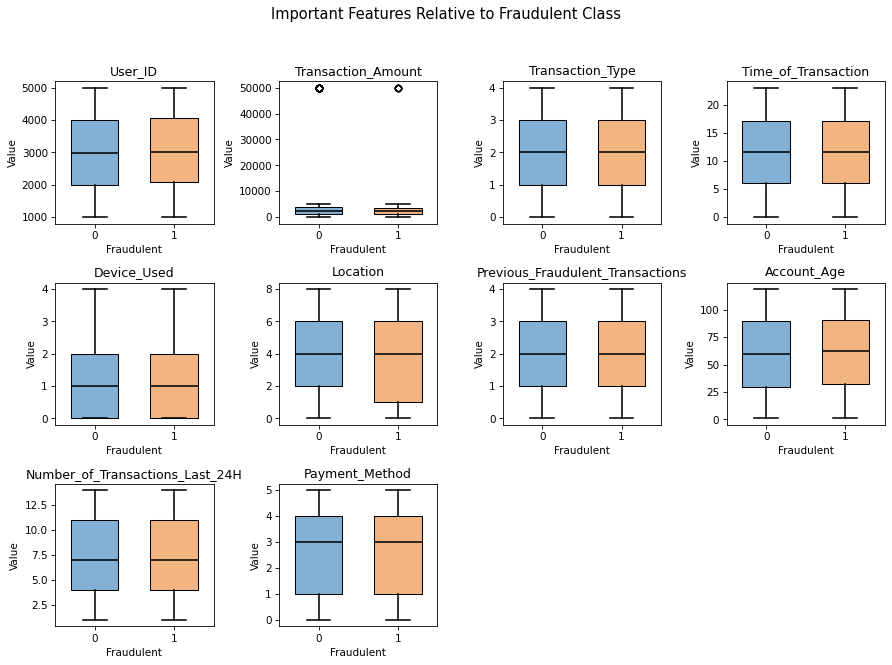

In [12]:
# Feature selection and visualization
X_eda = df_eda.drop(['Fraudulent'], axis=1)
y_eda = df_eda['Fraudulent']
important_features = preprocessor.select_features(X_eda, y_eda)
data_explorer.plot_feature_importance(df_eda, important_features)

### Interpretacja Danych

#### Ważność Cech

- **Kluczowe predyktory**:
  - `Device_Used`: 0.0027 MI
  - `Transaction_Type`: 0.0025 MI
  - `Location`: 0.0020 MI

- **Słabsze predyktory**:
  - `Transaction_Amount`: 0.00037 MI
  - `Time_of_Transaction`: 0.0014 MI

> Cechy z wyższym MI są lepszymi predyktorami fraudów.

## Przygotowanie Danych i Wizualizacja
- `prepare_ml_data`: balansuje dane SMOTE, skaluje i dzieli na zbiory treningowy/testowy.
- `get_metrics`: tworzy słownik metryk dla modelu.
- `Visualizer`: klasa grupuje metody wizualizacji: macierz pomyłek, wykres słupkowy metryk, interaktywny scatter porównujący modele.

In [13]:
def get_metrics(model_name, y_test, y_pred, y_proba):
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred, average="weighted"),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Recall": recall_score(y_test, y_pred, average="weighted"),
        "Precision": precision_score(y_test, y_pred, average="weighted")
        }

In [14]:
def prepare_ml_data(df_train: pd.DataFrame, target_col: str = 'Fraudulent', save_dir: str = "models") -> tuple:
    """Prepare data for ML modeling."""
    X = df_train.drop([target_col], axis=1)
    y = df_train[target_col]
    X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X, y)
    # Initialize and fit scaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_resampled)
    
    # Save scaler
    os.makedirs(save_dir, exist_ok=True)
    scaler_path = os.path.join(save_dir, "scaler.pkl")
    with open(scaler_path, "wb") as f:
        pickle.dump(scaler, f)
    print(f"Saved scaler to: {scaler_path}")

    # Save training columns
    training_cols = list(X.columns)
    cols_path = os.path.join(save_dir, "training_cols.pkl")
    with open(cols_path, "wb") as f:
        pickle.dump(training_cols, f)
    print(f"Saved training columns to: {cols_path}")
    
    return train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

In [15]:
# Prepare data
X_train, X_test, y_train, y_test = prepare_ml_data(df_train)


Saved scaler to: models/scaler.pkl
Saved training columns to: models/training_cols.pkl


In [16]:
class Visualizer:
    """Class for visualizing model performance using Matplotlib."""
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, model_name: str) -> None:
        """Plot confusion matrix using Matplotlib."""
        cm = confusion_matrix(y_true, y_pred)
        
        plt.figure(figsize=(5, 5), dpi=75)  # Rozmiar i DPI dla mniejszego pliku
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.title(f"Confusion Matrix - {model_name}", fontsize=12)
        plt.xlabel("Predicted", fontsize=10)
        plt.ylabel("True", fontsize=10)
        
        # Dodanie wartości tekstowych
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, cm[i, j], ha='center', va='center', fontsize=12, color='black')
        
        plt.xticks([0, 1], ["Class 0", "Class 1"])
        plt.yticks([0, 1], ["Class 0", "Class 1"])
        plt.colorbar()
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def plot_training_history(history, model_name: str) -> None:
        """Plot training history (accuracy and loss) using Matplotlib."""
        epochs = range(1, len(history.history['accuracy']) + 1)
        
        plt.figure(figsize=(12, 5), dpi=75)  # Dwa wykresy obok siebie
        plt.suptitle(f"Training History - {model_name}", fontsize=14)
        
        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history.history['accuracy'], 'b-', label='Train Accuracy')
        plt.plot(epochs, history.history['val_accuracy'], 'orange', label='Validation Accuracy')
        plt.title(f"{model_name} - Accuracy", fontsize=12)
        plt.xlabel("Epoch", fontsize=10)
        plt.ylabel("Accuracy", fontsize=10)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history.history['loss'], 'b-', label='Train Loss')
        plt.plot(epochs, history.history['val_loss'], 'orange', label='Validation Loss')
        plt.title(f"{model_name} - Loss", fontsize=12)
        plt.xlabel("Epoch", fontsize=10)
        plt.ylabel("Loss", fontsize=10)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Miejsce na suptitle
        plt.show()

    @staticmethod
    def plot_metrics_bar(results_df: pd.DataFrame) -> None:
        """Plot bar chart of model performance metrics using Matplotlib."""
        metrics = ['Accuracy', 'Recall', 'ROC AUC', 'Precision', 'F1 Score']
        melted_df = results_df.melt(id_vars=['Model'], value_vars=metrics, var_name='Metric', value_name='Score')
        
        models = results_df['Model'].unique()
        n_models = len(models)
        bar_width = 0.15
        index = np.arange(n_models)
        
        plt.figure(figsize=(10, 6), dpi=75)
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Kolory podobne do Vivid
        
        for i, metric in enumerate(metrics):
            scores = melted_df[melted_df['Metric'] == metric]['Score']
            plt.bar(index + i * bar_width, scores, bar_width, label=metric, color=colors[i])
        
        plt.title("Model Performance Metrics Comparison", fontsize=14)
        plt.xlabel("Model", fontsize=12)
        plt.ylabel("Score", fontsize=12)
        plt.ylim(0.80, 1.0)  # Zakres y jak w Plotly
        plt.xticks(index + bar_width * 2, models, rotation=45, ha='right')
        plt.legend(title="Metric", title_fontsize=12, fontsize=10)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
        
    @staticmethod
    def plot_model_comparison(results_df: pd.DataFrame, min_accuracy: float = 0.95) -> None:
        """Plot scatter chart for model comparison using Matplotlib."""
        filtered_df = results_df[results_df['Accuracy'] >= min_accuracy]
        
        plt.figure(figsize=(10, 6), dpi=75)
        scatter = plt.scatter(
            filtered_df["Accuracy"], 
            filtered_df["Recall"], 
            s=filtered_df["F1 Score"] * 500,  # Skalowanie rozmiaru
            c=filtered_df["ROC AUC"], 
            cmap="rainbow", 
            alpha=0.6, 
            edgecolors="w", 
            linewidth=0.5
        )
        
        # Dodanie etykiet modeli
        for i, row in filtered_df.iterrows():
            plt.text(row["Accuracy"], row["Recall"], row["Model"], fontsize=10, ha='center', va='bottom')
        
        plt.title("Model Performance Comparison", fontsize=14)
        plt.xlabel("Accuracy", fontsize=12)
        plt.ylabel("Recall (Weighted)", fontsize=12)
        plt.colorbar(scatter, label="ROC AUC")
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

## Trening

### Trening Modeli ML
Klasa `ModelTrainer` trenuje i ocenia 15 modeli ML na przeskalowanych, zbalansowanych danych, zwracając metryki i predykcje:

- `__init__`: konfiguruje GPU/CPU i definiuje modele z wagami klas.
- `train_and_evaluate`: trenuje modele, oblicza metryki (Accuracy, F1, ROC AUC, Recall, Precision).

In [17]:
class ModelTrainer:
    """Class for training and evaluating ML models with GPU memory management."""
    
    def __init__(self, use_gpu: bool = False, save_dir: str = "models"):
        """Initialize with GPU/CPU configuration and model dictionary."""
        self.use_gpu = use_gpu
        self.device = "cuda" if use_gpu and tf.config.list_physical_devices('GPU') else "cpu"
        self.task_type = "GPU" if use_gpu else "CPU"
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
        self.models = {
            "Logistic Regression": LogisticRegression(C=1.0, solver="liblinear", max_iter=500, class_weight="balanced"),
            "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=12, min_samples_split=5, class_weight="balanced_subsample", random_state=42),
            "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=10, criterion="gini", class_weight="balanced", random_state=42),
            "XGBoost": XGBClassifier(n_estimators=500, learning_rate=0.03, max_depth=7, scale_pos_weight=5, subsample=0.8, colsample_bytree=0.8, eval_metric="logloss", use_label_encoder=False, device=self.device),
            "LightGBM": LGBMClassifier(n_estimators=500, learning_rate=0.03, max_depth=7, num_leaves=60, min_data_in_leaf=5, force_col_wise=True, scale_pos_weight=5, verbose=-1),
            "Gradient Boosting": GradientBoostingClassifier(n_estimators=500, learning_rate=0.03, max_depth=7, min_samples_split=5),
            "SGD Classifier": SGDClassifier(loss="log_loss", penalty="l2", alpha=0.0001, max_iter=2000, tol=1e-4, class_weight="balanced"),
            "CatBoost": CatBoostClassifier(iterations=500, learning_rate=0.03, depth=7, l2_leaf_reg=5, scale_pos_weight=5, verbose=0, task_type=self.task_type),
            "SVM": SVC(kernel="rbf", C=1.0, probability=True, class_weight="balanced", random_state=42),
            "KNN": KNeighborsClassifier(n_neighbors=7, weights="distance", n_jobs=-1),
            "AdaBoost": AdaBoostClassifier(n_estimators=300, learning_rate=0.1, random_state=42),
            "Extra Trees": ExtraTreesClassifier(n_estimators=300, max_depth=12, min_samples_split=5, class_weight="balanced_subsample", random_state=42, n_jobs=-1),
            "HistGradientBoosting": HistGradientBoostingClassifier(max_iter=500, learning_rate=0.03, max_depth=7, random_state=42),
            "Naive Bayes": GaussianNB(),
            "MLPClassifier": MLPClassifier(hidden_layer_sizes=(256, 128, 64), max_iter=500, learning_rate_init=0.001, random_state=42)
        }
        print(f"Using {'GPU' if use_gpu else 'CPU'} for supported models.")
    
    def train_and_evaluate(self, X_train, X_test, y_train, y_test) -> tuple:
        """Train and evaluate models, returning performance metrics and predictions."""
        results = []
        predictions = {}
        probabilities = {}
        for name, model in self.models.items():
            print(f"Starting training: {name}")
            try:
                if name == "XGBoost":
                    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
                else:
                    model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                y_proba = model.predict_proba(X_test)[:, 1]
                predictions[name] = y_pred
                probabilities[name] = y_proba
                results.append(get_metrics(name, y_test, y_pred, y_proba))

                # Save the trained model
                model_path = os.path.join(self.save_dir, f"{name}_best_model.pkl")
                with open(model_path, 'wb') as f:
                    pickle.dump(model, f)
                print(f"Saved model: {model_path}")
                
                tf.keras.backend.clear_session()
                gc.collect()
            except Exception as e:
                print(f"Error training {name}: {str(e)}")
        results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
        return results_df, predictions, probabilities

# Train models
trainer = ModelTrainer(use_gpu=True)
results_df, predictions, probabilities = trainer.train_and_evaluate(X_train, X_test, y_train, y_test)

Using GPU for supported models.
Starting training: Logistic Regression
Saved model: models/Logistic Regression_best_model.pkl
Starting training: Random Forest
Saved model: models/Random Forest_best_model.pkl
Starting training: Decision Tree
Saved model: models/Decision Tree_best_model.pkl
Starting training: XGBoost
Saved model: models/XGBoost_best_model.pkl
Starting training: LightGBM
Saved model: models/LightGBM_best_model.pkl
Starting training: Gradient Boosting
Saved model: models/Gradient Boosting_best_model.pkl
Starting training: SGD Classifier
Saved model: models/SGD Classifier_best_model.pkl
Starting training: CatBoost
Saved model: models/CatBoost_best_model.pkl
Starting training: SVM
Saved model: models/SVM_best_model.pkl
Starting training: KNN
Saved model: models/KNN_best_model.pkl
Starting training: AdaBoost
Saved model: models/AdaBoost_best_model.pkl
Starting training: Extra Trees
Saved model: models/Extra Trees_best_model.pkl
Starting training: HistGradientBoosting
Saved mo

### Wyświetlanie Metryk

Wyświetla tabelę wyników.

In [18]:
# Display performance metrics
print("Model Performance Metrics:")
display(results_df)

Model Performance Metrics:


,Model,Accuracy,F1 Score,ROC AUC,Recall,Precision
5,Gradient Boosting,0.970819,0.970794,0.978195,0.970819,0.972405
12,HistGradientBoosting,0.964426,0.964381,0.976449,0.964426,0.966789
4,LightGBM,0.958136,0.958133,0.977636,0.958136,0.958248
14,MLPClassifier,0.947360,0.947360,0.974551,0.947360,0.947372
9,KNN,0.947102,0.947102,0.975252,0.947102,0.947110
3,XGBoost,0.946690,0.946688,0.978369,0.946690,0.946748
8,SVM,0.942411,0.942225,0.970595,0.942411,0.948166
0,Logistic Regression,0.925913,0.925538,0.947028,0.925913,0.934650
6,SGD Classifier,0.925758,0.925371,0.946626,0.925758,0.934767
7,CatBoost,0.924469,0.924409,0.975170,0.924469,0.925814


### Wydajność Modeli ML w Wykrywaniu Fraudów

#### W kontekście systemu bankowego do wykrywania fraudów, każda metryka ma specyficzne znaczenie:

- Accuracy (dokładność): odsetek poprawnie sklasyfikowanych transakcji. W systemie bankowym wysoka dokładność jest pożądana, ale może być myląca w niezbalansowanych danych (fraudy to ~5% transakcji), gdzie model może ignorować klasę mniejszościową.
- Recall (czułość): proporcja wykrytych fraudów (True Positives) do wszystkich rzeczywistych fraudów. Kluczowa w bankowości – wysoki Recall minimalizuje ryzyko przeoczenia oszustw (False Negatives), co ma wysoki koszt finansowy i reputacyjny.
- Precision (precyzja): proporcja poprawnie oznaczonych fraudów do wszystkich oznaczonych jako fraud. Wysoka precyzja redukuje fałszywe alarmy (False Positives), co jest istotne, by nie blokować legalnych transakcji klientów.
- F1 Score: średnia harmoniczna Precision i Recall. Najważniejsza metryka w tym systemie, bo równoważy wykrywanie fraudów z minimalizacją fałszywych alarmów – optymalizuje koszty operacyjne i zaufanie klientów.
- ROC AUC: miara zdolności modelu do rozróżniania klas. Wysokie ROC AUC wskazuje na skuteczność w separacji fraudów od normalnych transakcji, ale nie uwzględnia progu klasyfikacji, co w bankowości wymaga dodatkowego dostrojenia.

#### Najlepsze modele

##### Gradient Boosting
- F1 Score: 0.9708
- Accuracy: 0.9708
- ROC AUC: 0.9782
- Precyzja: 0.9724
- Czułość: 0.9708
> Najwyższa skuteczność, równowaga precyzji i czułości, doskonałe dopasowanie do danych fraudowych.

##### HistGradientBoosting
- F1 Score: 0.9644
- ROC AUC: 0.9764
- Precyzja: 0.9668
> Nieco niższa precyzja, ale solidna alternatywa.

##### LightGBM
- F1 Score: 0.9581
- ROC AUC: 0.9776
> Stabilne wyniki, choć słabsze od liderów.

#### Modele średnie

##### MLPClassifier, KNN, XGBoost
- F1 Score: 0.9467-0.9474
> Dobre, ale tracą na precyzji i czułości wobec topowych modeli gradientowych.

##### SVM
- F1 Score: 0.9422
- Precyzja: 0.9482
> Niższa wydajność, ale wysoka precyzja.

#### Najsłabsze modele

##### Naive Bayes
- F1 Score: 0.8026
> Najniższa skuteczność, prawdopodobnie z powodu założeń o niezależności cech.

##### AdaBoost
- F1 Score: 0.8329
> Słaba generalizacja w porównaniu do boostingów gradientowych.

#### ROC AUC
Wartości >0.975 dla Gradient Boosting, XGBoost, LightGBM wskazują na doskonałą zdolność rozróżniania klas, mimo niezbalansowania danych.

#### Wnioski
1. Gradient Boosting przewyższa inne modele w F1 Score i Accuracy, co sugeruje lepsze uchwycenie nieliniowych wzorców fraudowych.
2. Spadek wydajności w Naive Bayes i AdaBoost potwierdza ich ograniczenia w złożonych, niezbalansowanych danych.
3. Wysokie ROC AUC we wszystkich modelach (nawet słabszych) wskazuje na dobrą separację klas, ale F1 Score lepiej odzwierciedla praktyczną skuteczność w wykrywaniu fraudów.

### Macierze Pomyłek 
Wywołuje `plot_confusion_matrix` z klasy `Visualizer` dla każdego modelu, wizualizując błędy klasyfikacji.

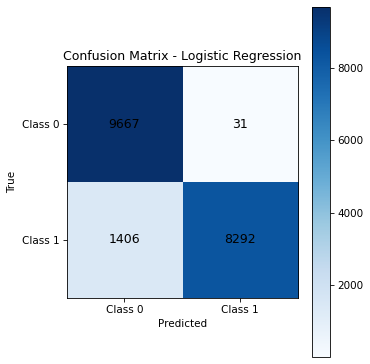

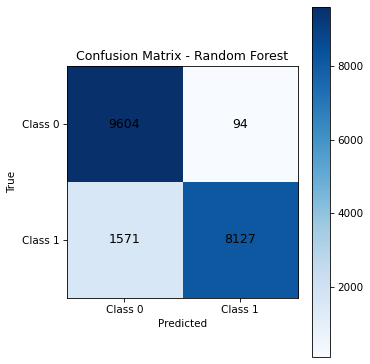

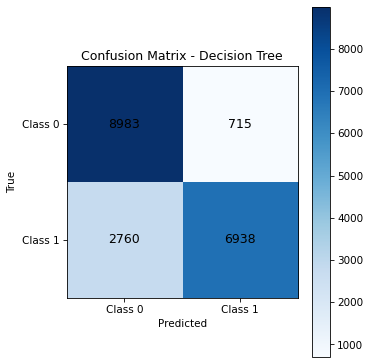

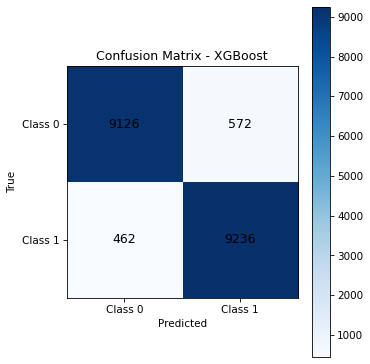

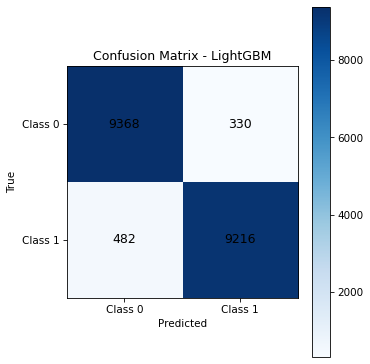

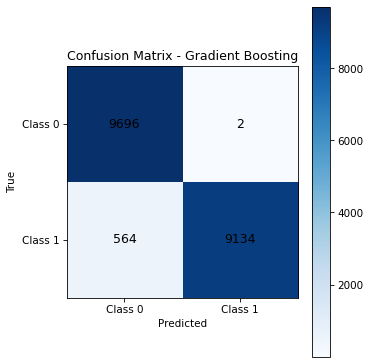

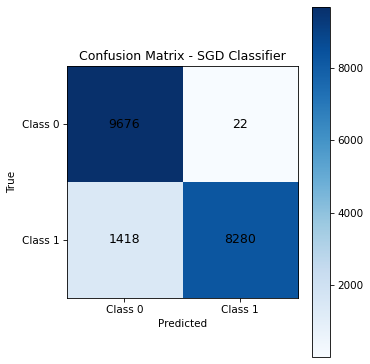

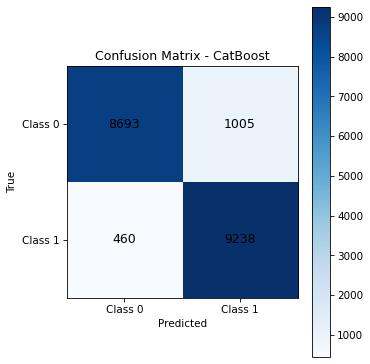

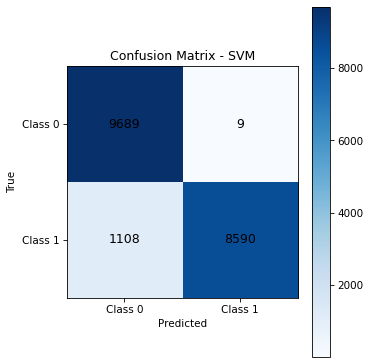

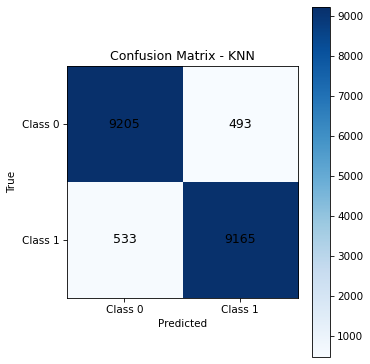

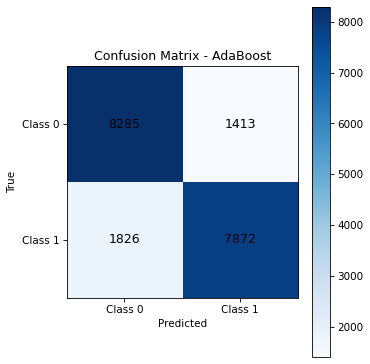

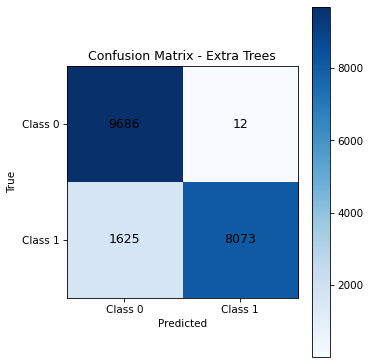

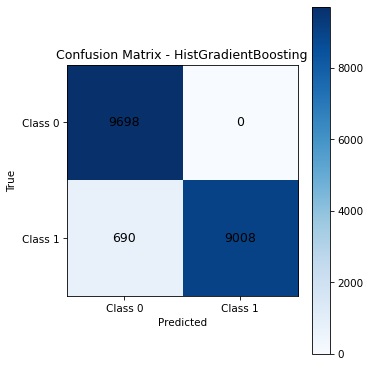

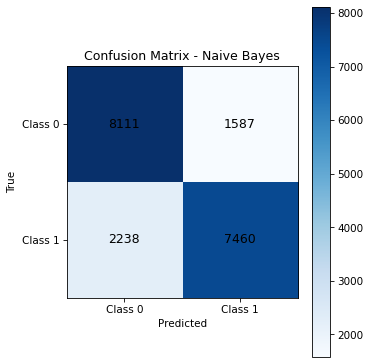

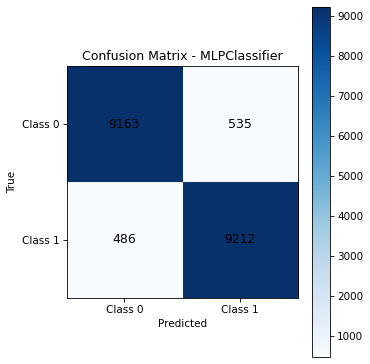

In [19]:
# Visualize confusion matrices
visualizer = Visualizer()
for model_name, y_pred in predictions.items():
    visualizer.plot_confusion_matrix(y_test, y_pred, model_name)

### Porównanie modeli
- `plot_metrics_bar`: rysuje słupkowy wykres metryk dla wszystkich modeli.
- `plot_model_comparison`: tworzy interaktywny scatter dla modeli z Accuracy ≥ 0.95.

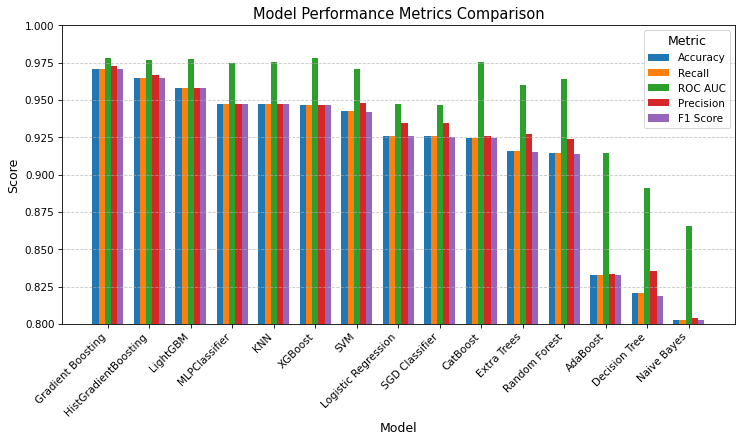

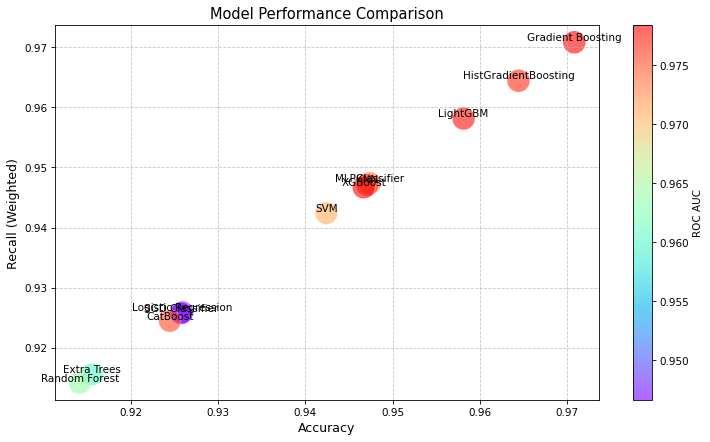

In [20]:
# Visualize performance metrics
Visualizer.plot_metrics_bar(results_df)
Visualizer.plot_model_comparison(results_df, min_accuracy=0.90)

### Trening Sieci Neuronowej
Klasa `NeuralNetworkTrainer` trenuje sieć neuronową na GPU/CPU:

- `__init__`: konfiguruje urządzenie i katalogi dla modeli/logs.
- `train_and_evaluate`: kompiluje model, trenuje z callbacks (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard), oblicza metryki.

In [21]:
class NeuralNetworkTrainer:
    """Class for training and evaluating neural networks."""
    
    def __init__(self, use_gpu: bool = True, save_dir: str = "models", log_dir: str = "logs"):
        """Initialize trainer with GPU support and directories."""
        self.use_gpu = use_gpu
        self.save_dir = save_dir
        self.log_dir = log_dir
        os.makedirs(save_dir, exist_ok=True)
        os.makedirs(log_dir, exist_ok=True)
        device_name = tf.test.gpu_device_name()
        self.device = device_name if use_gpu and device_name == '/device:GPU:0' else '/device:CPU:0'
        print(f"Using {self.device}")
    
    def train_and_evaluate(self, X_train, X_test, y_train, y_test, model, model_name: str = "Neural Network",
                          epochs: int = 50, batch_size: int = 128, initial_lr: float = 0.0005, threshold: float = 0.5) -> tuple:
        """Train and evaluate the model, returning results."""
        with tf.device(self.device):
            model.compile(optimizer=Adam(learning_rate=initial_lr), loss='binary_crossentropy', metrics=['accuracy'])
            print(f"\n{model_name} Model Summary:")
            model.summary()
            
            callbacks = [
                ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-8, verbose=1),
                EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1),
                ModelCheckpoint(os.path.join(self.save_dir, f"{model_name}_best_model.keras"), monitor='val_loss', save_best_only=True, mode='min', verbose=1),
                TensorBoard(log_dir=os.path.join(self.log_dir, f"{model_name}_{datetime.now().strftime('%Y%m%d-%H%M%S')}"), histogram_freq=1, write_graph=True, write_images=True, update_freq='epoch')
            ]
            
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)
            y_proba = model.predict(X_test)
            y_pred = (y_proba > threshold).astype(int).flatten()
            results = pd.DataFrame([get_metrics("Neural Network", y_test, y_pred, y_proba)])
            return model, history, y_pred, results

#### Monitorowanie Treningu
Włącza TensorBoard w Jupyter/Colab do analizy przebiegu treningu w czasie rzeczywistym.

In [22]:
# Enable TensorBoard inline (for Jupyter/Colab)
%load_ext tensorboard
%tensorboard --logdir logs

### Budowa i Trening DNN
- `create_default_model`: tworzy sieć z warstwami gęstymi, Dropout i BatchNormalization.
- Trening: inicjalizuje trening, przygotowuje dane i trenuje model.

In [23]:
def create_default_model(input_dim: int) -> Sequential:
    """Create a default neural network model."""
    model = Sequential([
        Dense(512, input_dim=input_dim, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(32, activation='relu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])
    return model

# Train the model
trainer = NeuralNetworkTrainer(use_gpu=True)
X_train, X_test, y_train, y_test = prepare_ml_data(df_train)
default_model = create_default_model(X_train.shape[1])
model_name = "Default_Neural_Network"
model, history, y_pred, dnn_results = trainer.train_and_evaluate(
    X_train, X_test, y_train, y_test, default_model, model_name=model_name,
    epochs=500, batch_size=64, initial_lr=0.001, threshold=0.425
)

Using /device:GPU:0
Saved scaler to: models/scaler.pkl
Saved training columns to: models/training_cols.pkl

Default_Neural_Network Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        14,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192,897 (753.50 KB)

 Trainable params: 190,913 (745.75 KB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/500
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8163 - loss: 0.4111
Epoch 1: val_loss improved from inf to 0.19726, saving model to models/Default_Neural_Network_best_model.keras
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8164 - loss: 0.4110 - val_accuracy: 0.9357 - val_loss: 0.1973 - learning_rate: 0.0010
Epoch 2/500
1202/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9275 - loss: 0.2169
Epoch 2: val_loss improved from 0.19726 to 0.18216, saving model to models/Default_Neural_Network_best_model.keras
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9275 - loss: 0.2169 - val_accuracy: 0.9407 - val_loss: 0.1822 - learning_rate: 0.0010
Epoch 3/500
1210/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.9328 - loss: 0.2074
Epoch 3: val_loss improved from 0.18216 to 0.18084, saving model to models/Default_Neural_Network_best_model.keras
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9328 - loss: 0.2074 - val_accuracy: 0.9412 - va

### Wykres Historii Treningu
Wywołuje `plot_training_history` z klasy `Visualizer` do wizualizacji Accuracy i Loss w Plotly.

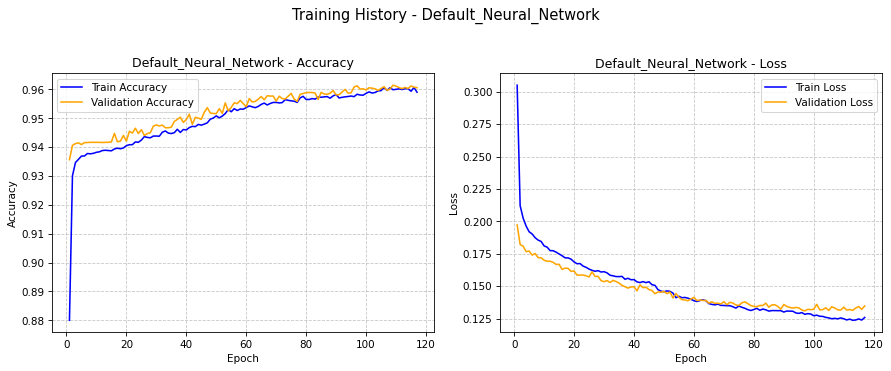

In [24]:
# Visualize training history
Visualizer.plot_training_history(history, model_name)

### Wyświetlanie Metryk DNN
Wyświetla tabelę wyników sieci neuronowej

In [25]:
# Display results
display(dnn_results)

,Model,Accuracy,F1 Score,ROC AUC,Recall,Precision
0,Neural Network,0.961642,0.961608,0.974127,0.961642,0.963253


### Wyświetlanie porównanie wszystkich modeli

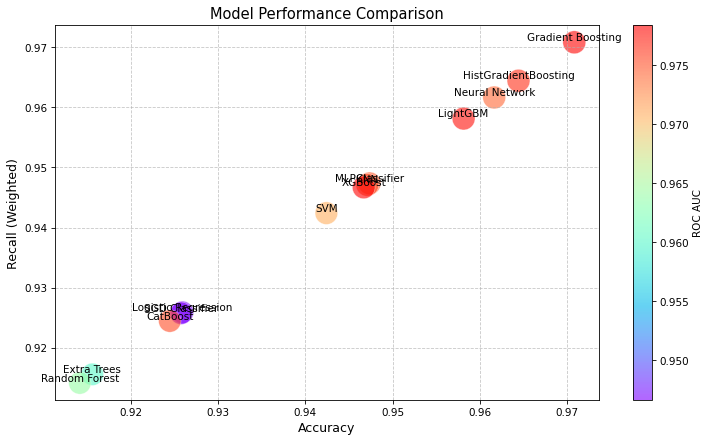

In [31]:
# Comparision chart
Visualizer.plot_model_comparison(pd.concat([results_df, dnn_results], ignore_index=True), 0.90)